In this notebook we demonstrate using BERT for the task of slot filling on the SNIPS dataset. The data can be found in folder for Ch6 in this repo.<br>
This notebook requires a GPU to get setup. We suggest you to run this on your local machine only if you have a GPU setup or else you can use google colab.

### Importing
Importing and installing the necessary libraries

In [1]:
#Installing required packages 
!pip install pytorch-pretrained-bert==0.4.0
!pip install seqeval==0.0.12

     |████████████████████████████████| 45 kB 1.3 MB/s 
     |████████████████████████████████| 131 kB 6.9 MB/s 
     |████████████████████████████████| 79 kB 7.7 MB/s 
     |████████████████████████████████| 7.9 MB 40.0 MB/s 
     |████████████████████████████████| 138 kB 53.4 MB/s 
     |████████████████████████████████| 127 kB 52.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7434 sha256=83402bcc4c317439244434cff615259badf1d4e0222eb75dff104a945af1eaff
  Stored in directory: /root/.cache/pip/wheels/dc/cc/62/a3b81f92d35a80e39eb9b2a

In [2]:
% tensorflow_version 1.x 

#importing packages for string processing,dataframe handling, array manipulations, etc
import string
import pandas as pd
import numpy as np
import json
from tqdm import tqdm, trange

#importing all the pytorch packages
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

#importing additonal packages to aid preprocessing of data
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#importing packages to calculate the f1_score of our model
from seqeval.metrics import f1_score

TensorFlow 1.x selected.
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


Uploading the file into google colab

In [3]:
!wget https://raw.githubusercontent.com/practical-nlp/practical-nlp-code/master/Ch6/Data/snips/train_PlayMusic_full.json
!wget https://raw.githubusercontent.com/practical-nlp/practical-nlp-code/master/Ch6/Data/snips/validate_PlayMusic.json

train_loc = "train_PlayMusic_full.json"
test_loc = "validate_PlayMusic.json"

--2021-09-02 03:11:06--  https://raw.githubusercontent.com/practical-nlp/practical-nlp-code/master/Ch6/Data/snips/train_PlayMusic_full.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 675343 (660K) [text/plain]
Saving to: ‘train_PlayMusic_full.json’

train_PlayMusic_ful 100%[===================>] 659.51K  --.-KB/s    in 0.05s   

2021-09-02 03:11:06 (12.4 MB/s) - ‘train_PlayMusic_full.json’ saved [675343/675343]

--2021-09-02 03:11:06--  https://raw.githubusercontent.com/practical-nlp/practical-nlp-code/master/Ch6/Data/snips/validate_PlayMusic.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [4]:
# try:
#     from google.colab import files
#     uploaded = files.upload()
#     train_loc = "train_PlayMusic_full.json"
#     test_loc = "validate_PlayMusic.json"
# except ModuleNotFoundError:
#     train_loc = "Data/snips/train_PlayMusic_full.json"
#     test_loc = "Data/snips/validate_PlayMusic.json"

Readind the json file

In [5]:
train_file = json.load(open(train_loc, encoding= "iso-8859-2"))
test_file = json.load(open(test_loc, encoding= "iso-8859-2"))

### Pre-Processing

In [6]:
train_datafile = [i["data"] for i in train_file["PlayMusic"]]
test_datafile = [i["data"] for i in test_file["PlayMusic"]]

Helper functions to process the data


In [7]:
train_file["PlayMusic"][0]

{'data': [{'text': 'I need to hear the '},
  {'entity': 'music_item', 'text': 'song'},
  {'text': ' '},
  {'entity': 'track', 'text': 'Aspro Mavro'},
  {'text': ' from '},
  {'entity': 'artist', 'text': 'Bill Szymczyk'},
  {'text': ' on '},
  {'entity': 'service', 'text': 'Youtube'}]}

In [8]:
train_datafile[0]

[{'text': 'I need to hear the '},
 {'entity': 'music_item', 'text': 'song'},
 {'text': ' '},
 {'entity': 'track', 'text': 'Aspro Mavro'},
 {'text': ' from '},
 {'entity': 'artist', 'text': 'Bill Szymczyk'},
 {'text': ' on '},
 {'entity': 'service', 'text': 'Youtube'}]

In [9]:
def convert_data(datalist):
    output = []
    for data in datalist:
        sent = []
        pos = []
        for phrase in data:
            words = phrase["text"].strip().split(" ")
            while "" in words:
                words.remove("")
            if "entity" in phrase.keys():
                label = phrase["entity"]
                labels = [label+"-{}".format(i+1) for i in range(len(words))]
            else:
                labels = ["O"] * len(words)
            sent.extend(words)
            pos.extend(labels)
        output.append([sent, pos])
        # print(sent)
    return output

In [10]:
train_data_dt = convert_data(train_datafile)
train_data_dt[0]

[['I',
  'need',
  'to',
  'hear',
  'the',
  'song',
  'Aspro',
  'Mavro',
  'from',
  'Bill',
  'Szymczyk',
  'on',
  'Youtube'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'music_item-1',
  'track-1',
  'track-2',
  'O',
  'artist-1',
  'artist-2',
  'O',
  'service-1']]

In [11]:
train_data = convert_data(train_datafile)
test_data = convert_data(test_datafile)

df_train = pd.DataFrame(train_data,columns=['sentence','label'])
df_test = pd.DataFrame(test_data,columns=['sentence','label'])
df_train.head()

,sentence,label
0,"[I, need, to, hear, the, song, Aspro, Mavro, f...","[O, O, O, O, O, music_item-1, track-1, track-2..."
1,"[play, Yo, Ho, from, the, new, york, pops, on,...","[O, track-1, track-2, O, artist-1, artist-2, a..."
2,"[Play, some, seventies, music, by, Janne, Puur...","[O, O, year-1, O, O, artist-1, artist-2, O, se..."
3,"[play, the, MĂşsica, Da, SĂŠrie, De, Filmes, O...","[O, O, album-1, album-2, album-3, album-4, alb..."
4,"[Play, Magic, Sam, from, the, thirties]","[O, artist-1, artist-2, O, O, year-1]"


We need to now get the unique labels

In [12]:
sentence = list(df_train['sentence'])+list(df_test['sentence'])#sentences in both test and train
label  = list(df_train['label'])+list(df_test['label'])#label in both test and train

unique_labels=[]
for i in label:
    unique_labels += i

labels = unique_labels # all the labels
unique_labels = set(unique_labels)#set of all the unique labels

list(unique_labels)[:10]

['track-8',
 'artist-5',
 'album-2',
 'service-1',
 'track-6',
 'track-4',
 'playlist-1',
 'artist-3',
 'track-7',
 'artist-6']

In [13]:
label_dt = list(df_train['label'])+list(df_test['label'])
label_dt[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'music_item-1',
 'track-1',
 'track-2',
 'O',
 'artist-1',
 'artist-2',
 'O',
 'service-1']

In [14]:
sentence[:2]

[['I',
  'need',
  'to',
  'hear',
  'the',
  'song',
  'Aspro',
  'Mavro',
  'from',
  'Bill',
  'Szymczyk',
  'on',
  'Youtube'],
 ['play', 'Yo', 'Ho', 'from', 'the', 'new', 'york', 'pops', 'on', 'Youtube']]

We need to join all the tokens into a single sentence. We will use the untokenize function in token_utils from [this](https://github.com/commonsense/metanl/blob/master/metanl/token_utils.py) github repo.


In [15]:
import re
def untokenize(words):
    """
    Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

sentences_untokenized = [untokenize(i) for i in sentence]

In [16]:
sentences_untokenized[0]

'I need to hear the song Aspro Mavro from Bill Szymczyk on Youtube'

In [17]:
#setting up pytorch to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

#prescribed configurations that we need to fix for BERT.
MAX_LEN = 75
bs = 32

#BERT's implementation comes with a pretained tokenizer and a defined vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#tokenizing the text
tokenized_texts = [["[CLS]"] +tokenizer.tokenize(sent)+ ["[SEP]"] for sent in sentences_untokenized]
print(tokenized_texts[:2])

100%|██████████| 231508/231508 [00:00<00:00, 320659.16B/s]


[['[CLS]', 'i', 'need', 'to', 'hear', 'the', 'song', 'as', '##pro', 'ma', '##vr', '##o', 'from', 'bill', 's', '##zy', '##mc', '##zy', '##k', 'on', 'youtube', '[SEP]'], ['[CLS]', 'play', 'yo', 'ho', 'from', 'the', 'new', 'york', 'pops', 'on', 'youtube', '[SEP]']]


In [18]:
np.array(labels).shape

(15292,)

In [19]:
#pre-processing the labels
tags_vals = list(unique_labels)
tag2idx = {t: i for i, t in enumerate(tags_vals)}
tags_vals[:10]

['track-8',
 'artist-5',
 'album-2',
 'service-1',
 'track-6',
 'track-4',
 'playlist-1',
 'artist-3',
 'track-7',
 'artist-6']

In [42]:
print(list(tag2idx)[:2])
print(tag2idx["O"])

['track-8', 'artist-5']
28


In [20]:
#cutting and padding the tokens and labels to our desired length
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in label],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [46]:
print(label[0])
print(tags[0])
print(input_ids[0])
print(tags.shape)

['O', 'O', 'O', 'O', 'O', 'music_item-1', 'track-1', 'track-2', 'O', 'artist-1', 'artist-2', 'O', 'service-1']
[28 28 28 28 28 37 38 17 28 30 10 28  3 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28]
[  101  1045  2342  2000  2963  1996  2299  2004 21572  5003 19716  2080
  2013  3021  1055  9096 12458  9096  2243  2006  7858   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
(2100, 75)


In [21]:
#BERT supports something called attention masks
#Tells the model which tokens should be attended to, and which should not.
#learn more about this at https://huggingface.co/transformers/glossary.html#attention-mask

attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [22]:
#split the dataset to use 10% to validate the model.
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [23]:
#pytorch requires inouts to be in the form of torch tensors
#Learn more about torch tensors at https://pytorch.org/docs/stable/tensors.html
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [24]:
#Define the Data Loaders
#Shuffle the data at training time
#Pass them sequentially during test time
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [25]:
#Fine-Tuning BERT
# BertForTokenClassification class of pytorch-pretrained-bert package provides  for token-level predictions
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))

100%|██████████| 407873900/407873900 [00:30<00:00, 13391250.20B/s]


In [26]:
#Passing model parameters into GPU
if torch.cuda.is_available():
    model.cuda()
else:
    model

In [57]:
list(model.named_parameters())[0] #4

('bert.embeddings.word_embeddings.weight', Parameter containing:
 tensor([[-0.0105, -0.0621, -0.0265,  ..., -0.0200, -0.0372, -0.0104],
         [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
         [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
         ...,
         [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
         [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
         [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
        device='cuda:0', requires_grad=True))

In [27]:
#Before starting fine tuing we need to add the optimizer. Generally Adam is used
#weight_decay is added as regularization to the main weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [28]:
#accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [71]:
count = 0
for step, batch in enumerate(train_dataloader):
  if count < 1:

    # add batch to gpu
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    

    count += 1

print(b_labels[0])
print(b_input_ids.size())   

tensor([28, 37, 28, 30, 28,  3, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28], device='cuda:0')
torch.Size([32, 75])


In [29]:
#Add the epoch number. 
#Link to the paper https://arxiv.org/abs/1810.04805
epochs = 5
max_grad_norm = 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

train_loss_set = []

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))



    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.45937001928687093


Epoch:  20%|██        | 1/5 [01:01<04:05, 61.43s/it]

Validation loss: 0.13167092097657068
Validation Accuracy: 0.9694113756613757
F1-Score: 0.5288461538461539
Train loss: 0.11288481801748276


Epoch:  40%|████      | 2/5 [02:02<03:03, 61.18s/it]

Validation loss: 0.08097447188837188
Validation Accuracy: 0.9787896825396825
F1-Score: 0.717607973421927
Train loss: 0.07331619144727787


Epoch:  60%|██████    | 3/5 [03:03<02:02, 61.09s/it]

Validation loss: 0.06102111403431211
Validation Accuracy: 0.981521164021164
F1-Score: 0.7500000000000001
Train loss: 0.052866715316971145


Epoch:  80%|████████  | 4/5 [04:04<01:00, 61.00s/it]

Validation loss: 0.04830455354281834
Validation Accuracy: 0.9853240740740741
F1-Score: 0.7964169381107492
Train loss: 0.038291506713721904


Epoch: 100%|██████████| 5/5 [05:04<00:00, 61.00s/it]

Validation loss: 0.04354745176221643
Validation Accuracy: 0.9868518518518518
F1-Score: 0.8152260111022998


In [61]:
train_loss_set[0]

3.6634435653686523

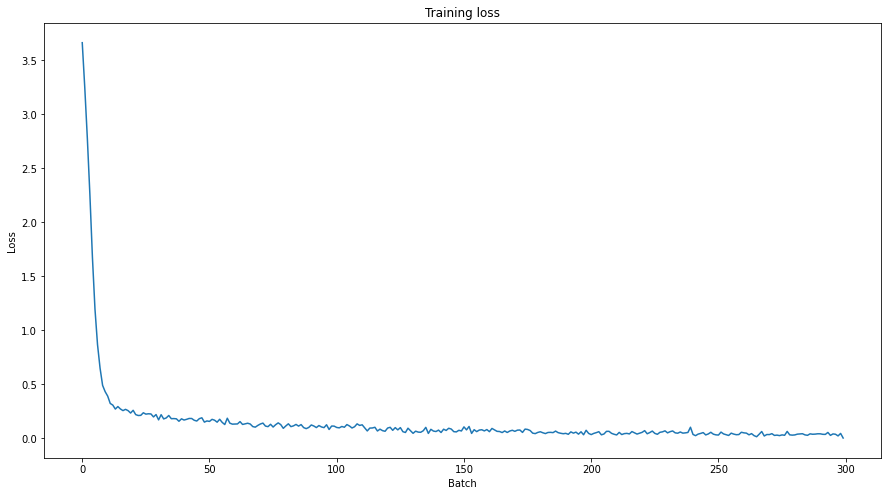

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()